# Sync with Google Drive

In [0]:
from google.colab import drive

drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive


# Installing Libraries

In [0]:
!pip install pillow progressbar2

# Importing Libraries

In [0]:
import os, sys

# Check to your repository here
if os.getcwd() != '/content/gdrive/My Drive/Udacity/PyTorch Challenge':
  os.chdir('/content/gdrive/My Drive/Udacity/PyTorch Challenge')
  
sys.path.append(os.getcwd())

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils import data
from torchvision import transforms, datasets, models
from collections import OrderedDict
import json
from PIL import Image
import matplotlib as plt
from utils import sanity_check

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Loading the Data

As we are only using this notebook to show model predictions, we'll only load the validation images.

In [0]:
base_path = 'flower_data'
batch_size = 64

In [0]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

valid_dataset = datasets.ImageFolder(os.path.join(base_path, 'valid'),
                                     transform=valid_transforms)

valid_loader = data.DataLoader(valid_dataset,
                               batch_size=batch_size,
                               shuffle=True)

In [0]:
# Creating a dictionary to map the index of the flowers categories to its actual names

with open('flower_data/cat_to_name.json') as f:
  cat_to_name = json.load(f)
  
name_to_cat = {}

for k, v in cat_to_name.items():
  name_to_cat[v] = k

# Loading the Model

Resnet152 with $\mathbf{98.92}\%$ on validation set.

In [0]:
def resnet():
  model = models.resnet152(pretrained=True)
  
  for param in model.parameters():
    param.requires_grad = False
    
  fc = nn.Sequential(OrderedDict([
      ('fc1', nn.Linear(2048, 1024)),
      ('relu', nn.ReLU()),
      ('dropout', nn.Dropout(0.5)),
      ('fc2', nn.Linear(1024, 512)),
      ('relu', nn.ReLU()),
      ('dropout', nn.Dropout(0.5)),
      ('output', nn.Linear(512, 102))
  ]))
  
  model.fc = fc
  
  return model


def load_pretrained_model(ckpt_path, model_fn):
  model = model_fn()
  
  state_dict = torch.load(ckpt_path)
  model.load_state_dict(state_dict)
  
  return model

In [0]:
ckpt_path = '../FinalChallenge/best-model/9892/model_9892.pt'

model = load_pretrained_model(ckpt_path, resnet)

model.idx_to_class = cat_to_name
model.to_idx = { str(v): k for k, v in valid_dataset.class_to_idx.items() }

model.eval()


# Making Predictions

In [0]:
iterator = iter(valid_loader)
x, y = next(iterator)

softmax = nn.Softmax(dim=1)

In [0]:
def get_random_data(x, y):
  batch_size = len(x)
  random_number = np.random.randint(batch_size)
  
  return x[random_number], y[random_number]

In [0]:
image, label = get_random_data(x, y)

image.unsqueeze_(0)
output = model(image)
probs = softmax(output)

probs.topk(5, dim=1)

(tensor([[9.9933e-01, 5.7880e-04, 7.0180e-05, 2.0383e-05, 9.1571e-07]],
        grad_fn=<TopkBackward>), tensor([[72, 26, 27, 40, 94]]))

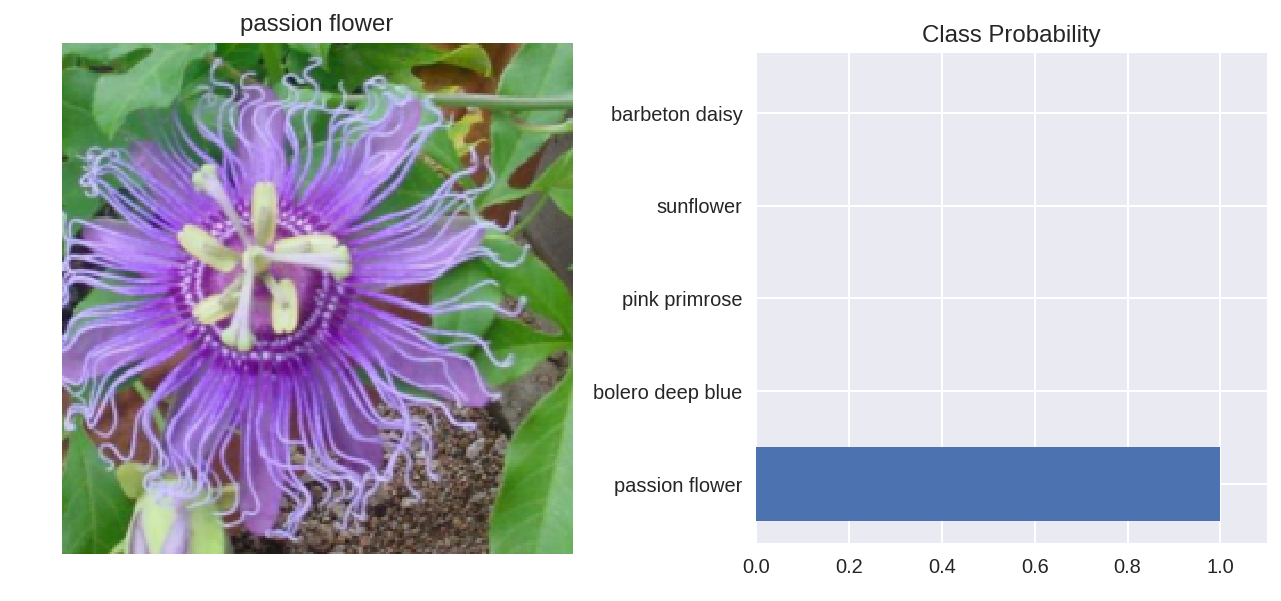

In [0]:
image, label = get_random_data(x, y)

sanity_check(image, label, model)